In [1]:
from train import resnet_classification

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from classification_dataload import ClassificationDataset
from matplotlib import pyplot as plt
import util
import numpy
from collections import Counter

import importlib
from sklearn import metrics
rl = importlib.reload

In [2]:
target_category='species_binary'
model_ft, hist = resnet_classification(loading_model=True, model_name='resnet101_species_binary_cropBtm', target_category = target_category)

Loading customized pre-trained model


In [3]:
model_ft.eval()
image_root = 'image'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_datasets = {x: ClassificationDataset(set_name=x, root_dir=image_root, target_category=target_category, flip_image=False)
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                          shuffle=False, num_workers=6)
           for x in ['train', 'val', 'test']}

In [22]:
val_data = dataloaders['val']
train_data = dataloaders['train']
test_data = dataloaders['test']

dataset = test_data

In [23]:
classes = dataset.dataset.classes
maps = dataset.dataset.species_classes_map

In [24]:
len(dataset.dataset)

186

In [25]:
Counter(train_data.dataset.data_set_species)

Counter({'Animal': 811, 'Ghost': 667})

In [26]:
Counter(val_data.dataset.data_set_species)

Counter({'Animal': 108, 'Ghost': 80})

In [27]:
Counter(test_data.dataset.data_set_species)

Counter({'Animal': 103, 'Ghost': 83})

In [28]:
maps

{'Ghost': 0, 'Animal': 1}

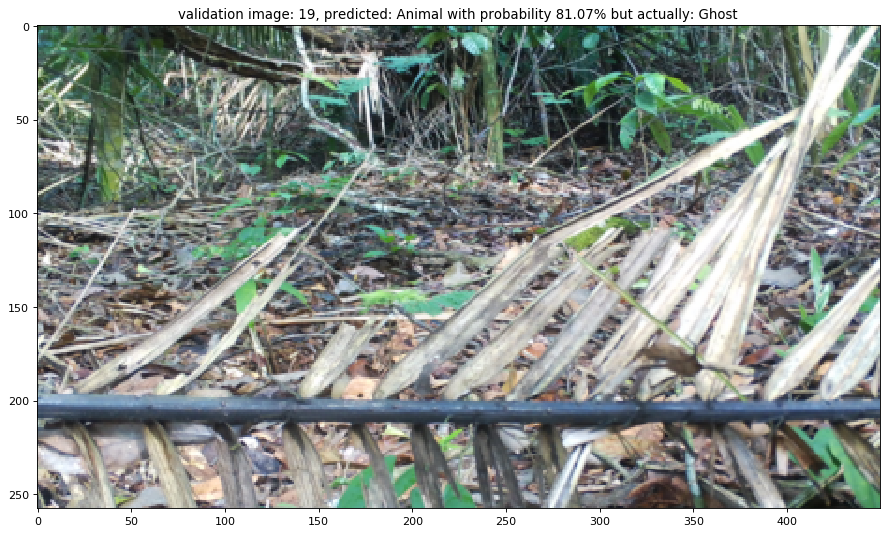

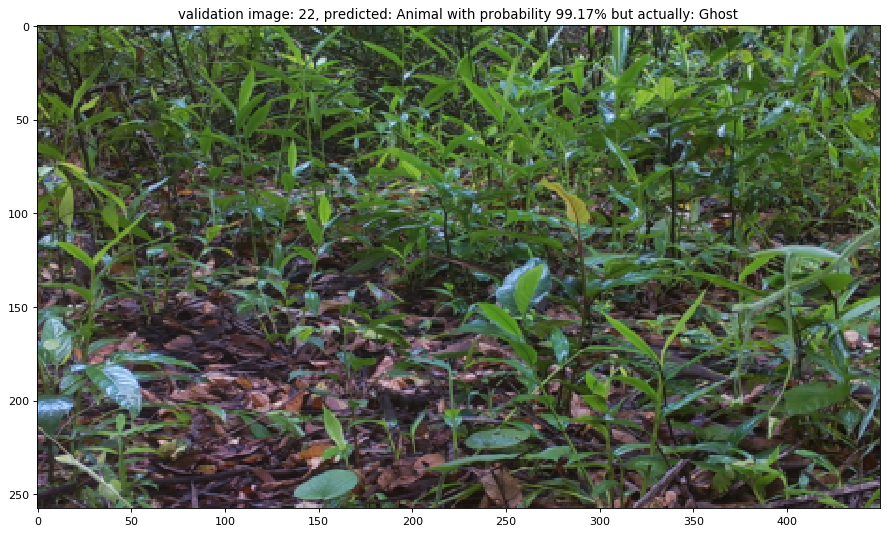

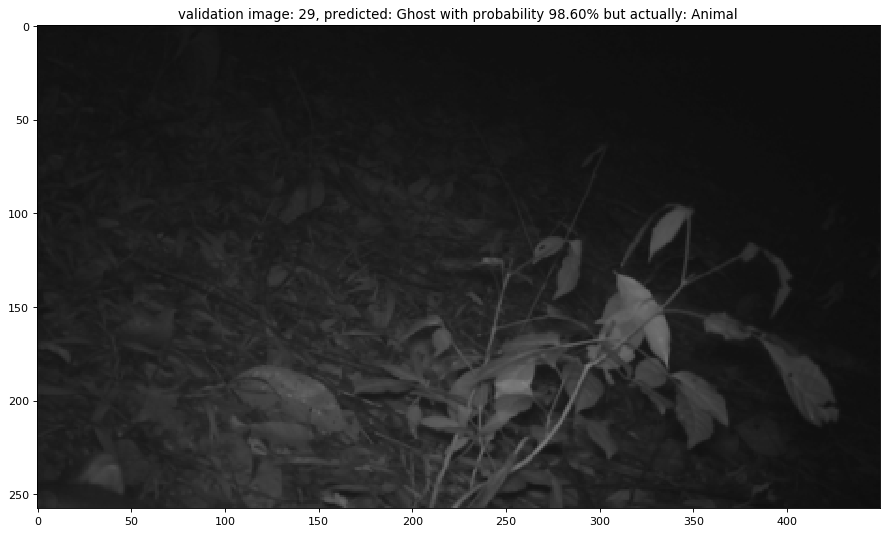

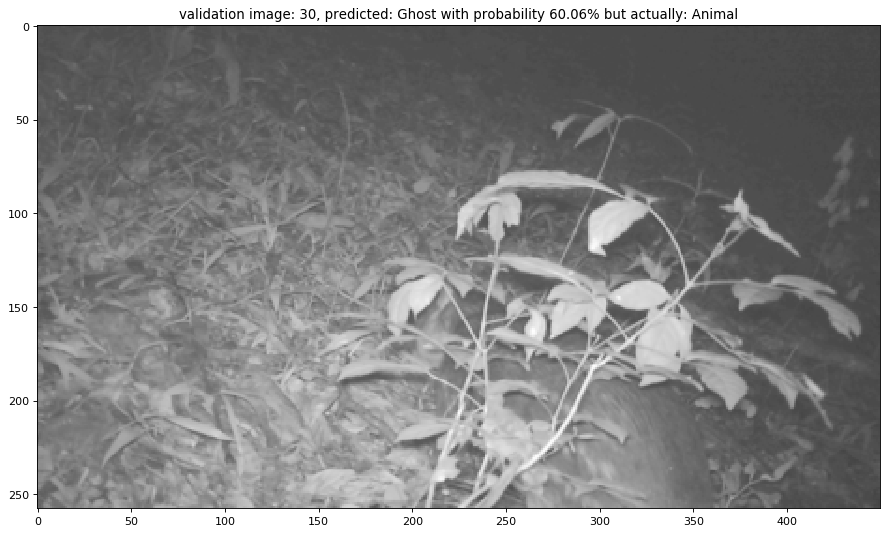

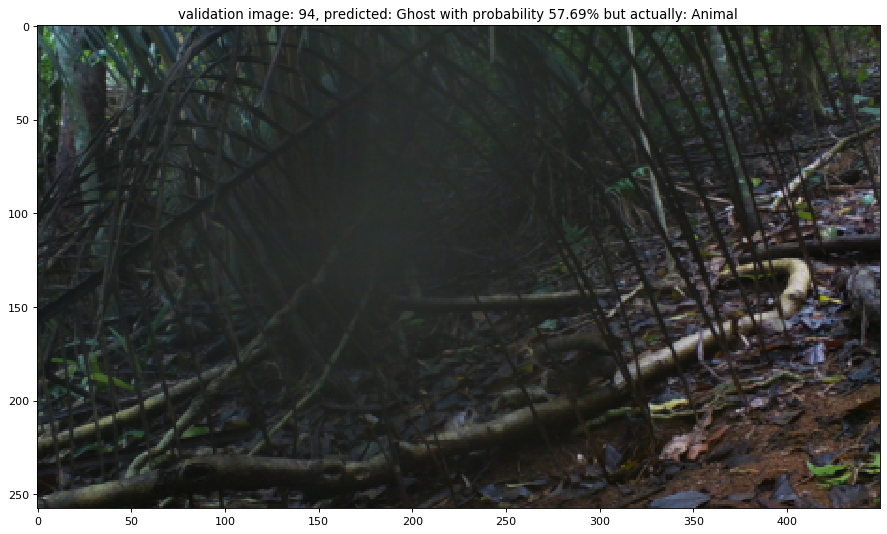

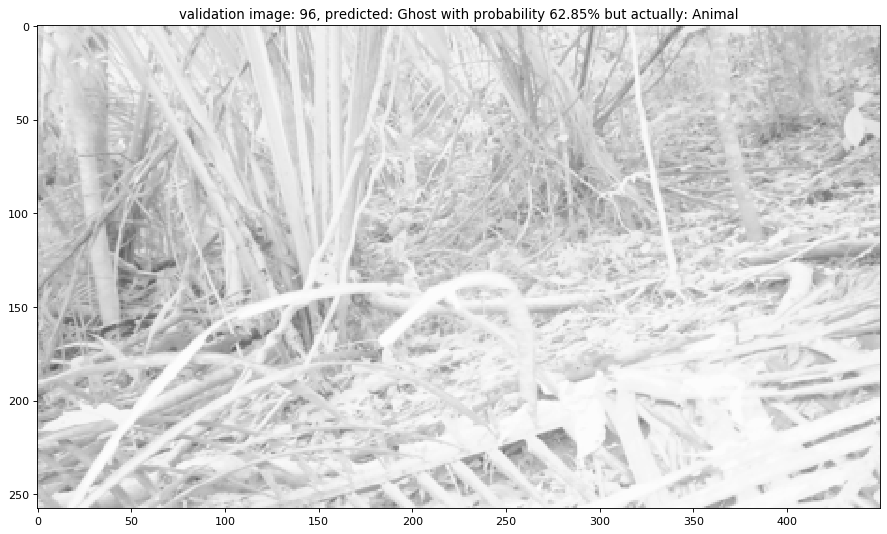

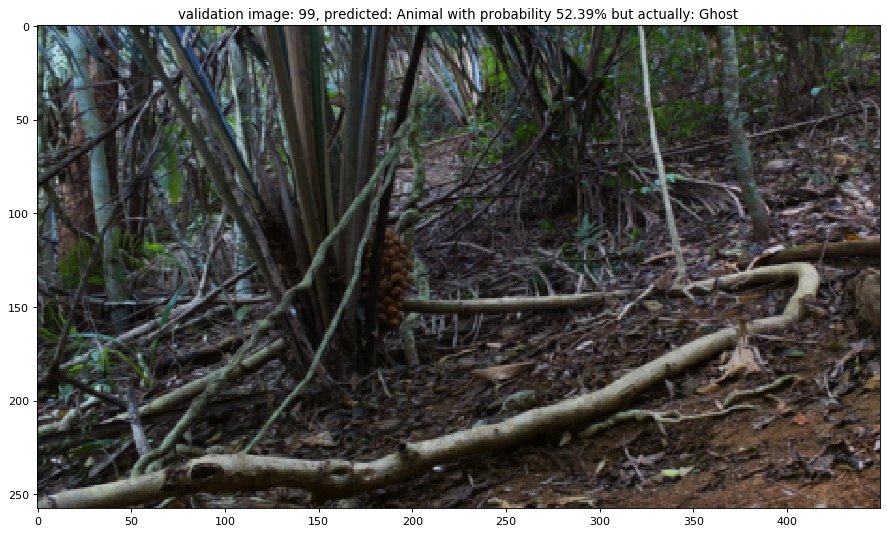

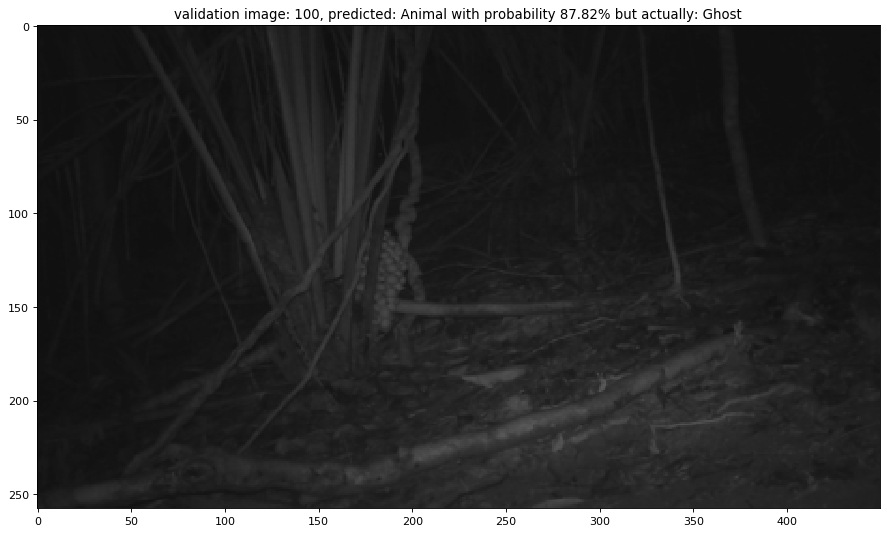

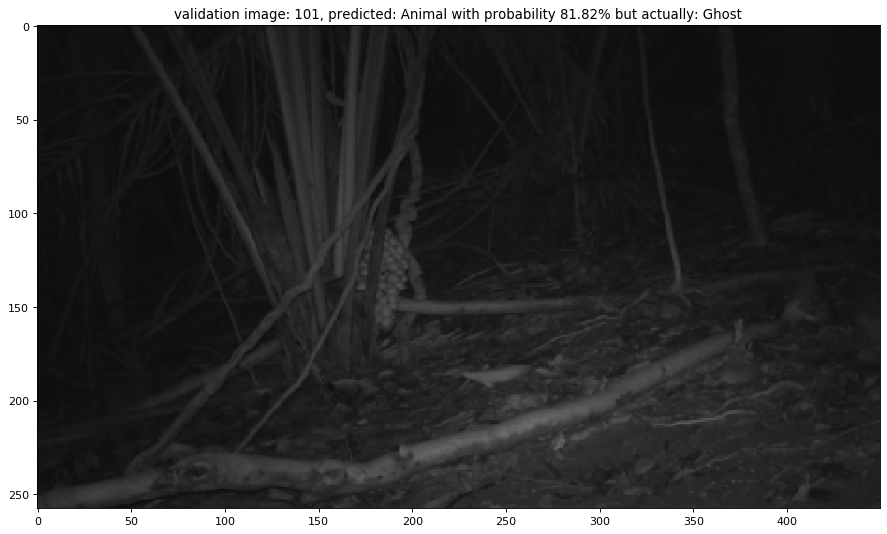

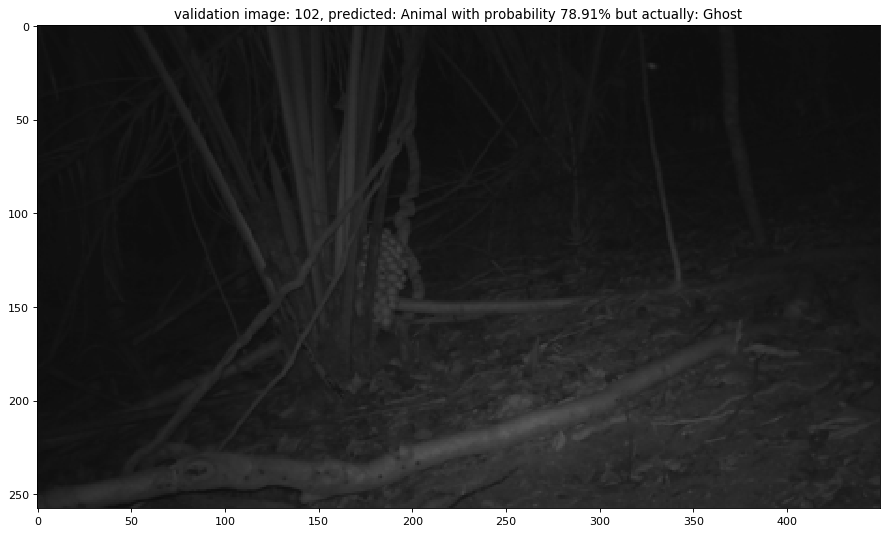

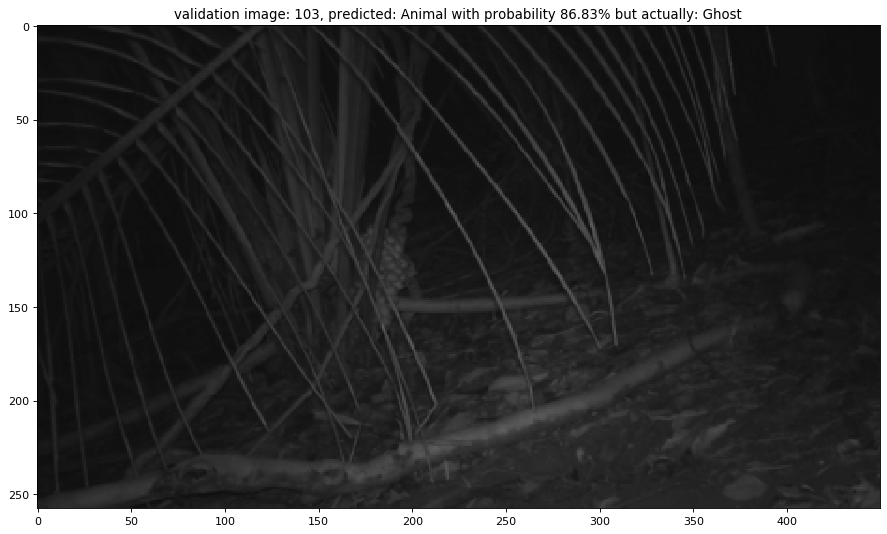

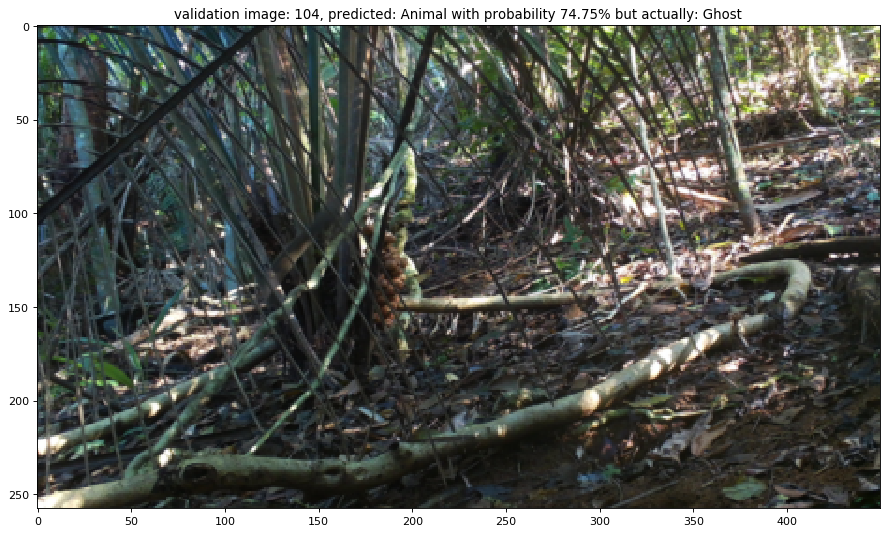

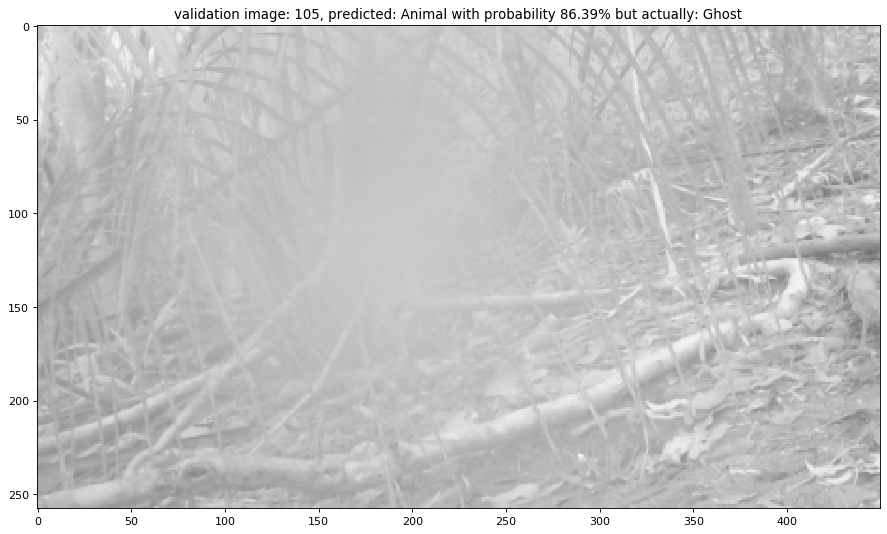

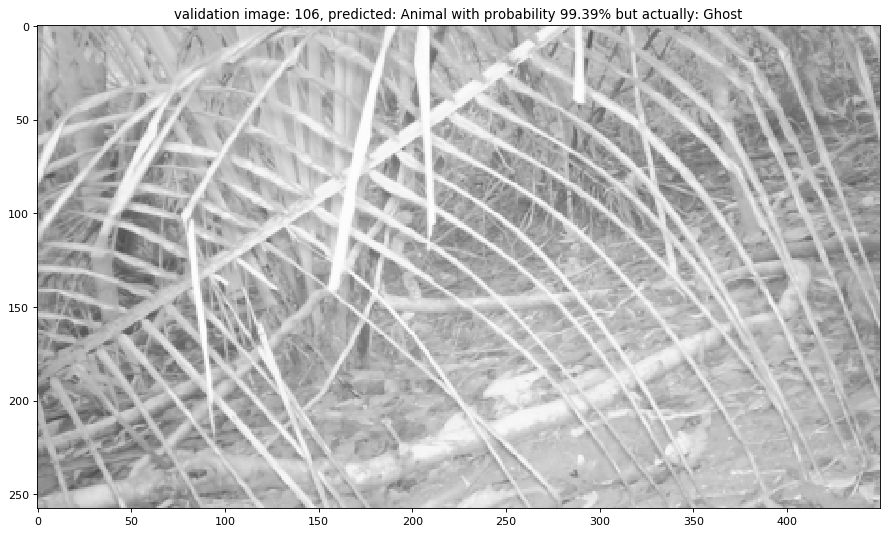

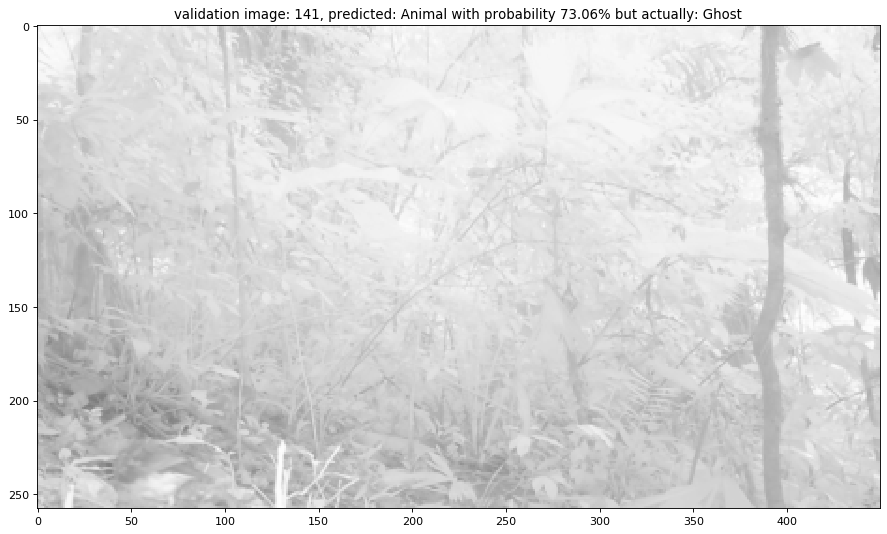

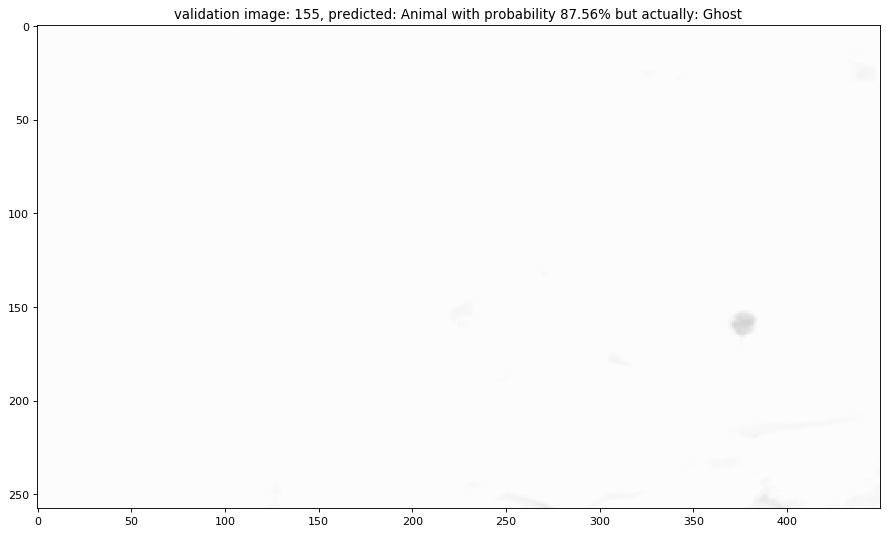

In [29]:
pred_list = []
actual_list = []
probablity_list = []
softmax = torch.nn.Softmax(dim=1)
misclassified_index = []

cam_trap = numpy.array(dataset.dataset.cam_trap)

with torch.no_grad():
    for image_index, (inputs, labels) in enumerate(dataset):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        actual_list += labels.tolist()

        outputs = model_ft(inputs)
        prob = softmax(outputs).tolist()
        probablity_list += prob
        
        _, preds = torch.max(outputs, 1)
        pred_list += preds.tolist()
        
        if any(preds != labels):
            misclassified_index += [image_index]
            util.imshow(inputs[preds != labels, :, :, :].cpu(), 
                        title=['validation image: {}, predicted: {} with probability {:.2f}% but actually: {}'.format(image_index, classes[int(preds[i])], max(prob[0])*100,classes[int(labels[i])]) 
                               for i in range(len(preds)) if labels[i] !=preds[i]],
                       savefig='savefig/validation_image_{}_camptrap_{}.png'.format(image_index, cam_trap[image_index]))

In [30]:
Counter(numpy.array(dataset.dataset.cam_trap)[misclassified_index])

Counter({'CT08': 1,
         'CT06': 1,
         'CT01': 2,
         'SSAMLD2': 10,
         'SS CAM5': 1,
         'SS CAM6': 1})

In [31]:
Counter(numpy.array(dataset.dataset.cam_trap))

Counter({'SSAMLD2_2': 19,
         'CT08': 2,
         'CT06': 6,
         'CT01': 46,
         'SSAMLD2': 58,
         'CT04': 7,
         'SS CAM4': 2,
         'SS CAM3': 1,
         'SS CAM5': 2,
         'SS CAM19': 8,
         'SS CAM7': 3,
         'SS CAM6': 2,
         'SS CAM1': 21,
         'SS CAM8': 9})

In [32]:
sum(numpy.array(pred_list) != numpy.array(actual_list))

16

In [33]:
metrics.confusion_matrix(y_true=actual_list, y_pred=pred_list).T

array([[71,  4],
       [12, 99]], dtype=int64)

In [34]:
metrics.precision_score(y_true=actual_list, y_pred=pred_list, pos_label=0)

0.9466666666666667

In [35]:
metrics.recall_score(y_true=actual_list, y_pred=pred_list, pos_label=0)

0.8554216867469879

In [36]:
metrics.accuracy_score(y_true=actual_list, y_pred=pred_list)

0.9139784946236559

In [37]:
metrics.f1_score(y_true=actual_list, y_pred=pred_list)

0.9252336448598131

In [38]:
lr_probs = numpy.array(probablity_list)[:,0]
testy = 1 - numpy.array(actual_list)


No Skill: ROC AUC=0.500
Model: ROC AUC=0.950


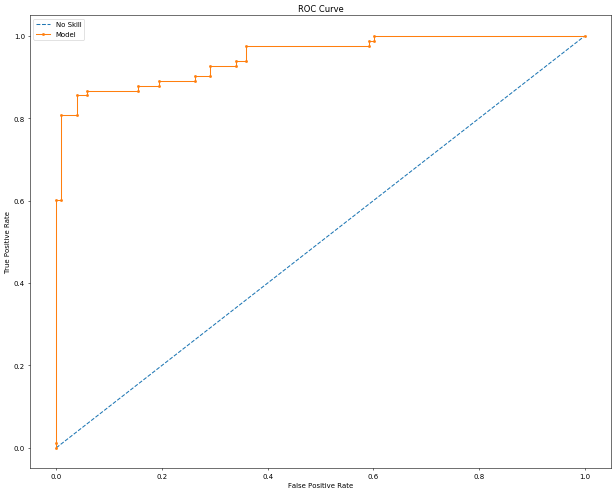

In [39]:
rl(util)
util.roc(lr_probs, testy, savefig='savefig/roc_resnet50.png')

In [ ]:
rl(util)
util.prc(pred_list,lr_probs, testy, savefig='savefig/prc_resnet50.png')

In [ ]:
util.acc_curve(hist, savefig='binary_acc')

In [ ]:
util.loss_curve(hist, savefig='binary_loss')